In [1]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

import numpy as np
from functools import partial
import matplotlib
import matplotlib.pyplot as plt

import elfi

matplotlib.style.use('ggplot')
%matplotlib inline

# Using external operations with ELFI

If your simulator or other operations are implemented in a programming language other than Python, you can still use ELFI. This notebook briefly demonstrates how to do this in 3 common requirements:

* External executable (written e.g. in C++)
* R function
* MATLAB function

**Note** that to run this notebook you need to compile the simulator, have both R and MATLAB installed, and install the appropriate wrapper libraries (see below).

## External executables

ELFI supports using an external simulator and other operations that can be called from the command-line. This functionality is briefly introduced in this notebook. For a more concrete tutorial on ELFI and the MA2 model, please see the MA2 tutorial notebook.

Let's start by defining some constants:

In [2]:
n_obs = 100
t1_0 = 0.6
t2_0 = 0.2
random_state = np.random.RandomState(20161130)

Now we can set up a simulator as a **precompiled** executable that accepts command-line arguments. The placeholders for arguments in the command string will be replaced by ELFI using Python's [`format`](https://docs.python.org/3/library/string.html#formatstrings). If the simulator accepts a seed for random number generation, please use the name `seed`. In this case the number of observations, `n_obs`, is the last argument for the executable, but we set it already here using `partial`, so we give it the index 0.

In [3]:
# Set up the simulator (assume current dir is elfi/notebooks and ma2.bin compiled)
command = "../examples/cpp/ma2/ma2.bin {1} {2} {seed} {0}"
simulator = partial(elfi.Wrapper(command), n_obs)

Now the simulator can be run inside the Python interface. By default its output is read from `stdout` as a space-limited array that is converted into a numpy array.

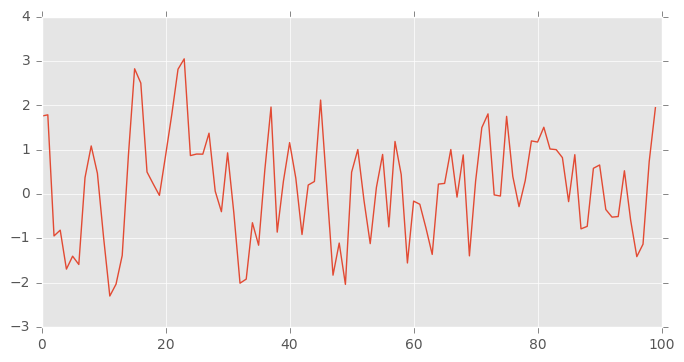

In [4]:
# Set up observed data y
y_obs = simulator(t1_0, t2_0, random_state=random_state)

# Plot
plt.figure(figsize=(8, 4));
plt.plot(y_obs.ravel());

Custom parsers for both preprocessing and postprocessing may be given when initializing the `Wrapper`. For example, you could use the Numpy functions `savetxt` and `genfromtxt` if your simulator reads input from a file and writes its output to another:

In [5]:
def preproc_parser(command, args, kwargs):
    np.savetxt('my_input.dat', np.array(args))
    return command, proc_args, kwargs
    
def postproc_parser(_):
    return np.genfromtxt('my_output.dat')

# You could then give these when defining your simulator:
# my_simulator = elfi.Wrapper(my_command, pre=preproc_parser, post=postproc_parser)

## Interfacing with R

It is possible to run R scripts in command line for example with [Rscript](http://stat.ethz.ch/R-manual/R-devel/library/utils/html/Rscript.html). However, in Python it may be more convenient to use [rpy2](http://rpy2.readthedocs.io), which allows convenient access to the functionality of R from within Python.

Here we demonstrate how to calculate the summary statistics used in the MA2 tutorial (autocovariances with lags 1 and 2) using R's `acf` function.

In [6]:
import rpy2.robjects as robj

Some boilerplate is required, so let's create a Python function that wraps the R commands (please see the documentation of [rpy2](http://rpy2.readthedocs.io) for details):

In [7]:
def autocovR(x, lag):
    xR = robj.FloatVector(x.ravel())  # convert Numpy array to a vector in R
    acfR = robj.r['acf']  # get a reference to R's acf object
    ansR = acfR(xR, plot=False, type='covariance', lag_max=lag)  # call R function with Python syntax
    ans = ansR.rx2('acf')[lag]  # extract the requested value from the R object
    return np.atleast_2d(ans)  # return as Numpy array

Set up summary statistics just like earlier:

In [8]:
ac1 = partial(autocovR, lag=1)
ac2 = partial(autocovR, lag=2)

## Interfacing with MATLAB

There are a number of options for running MATLAB (or Octave) scripts from within Python. Here, evaluating the discrepancy is demonstrated with MATLAB's `norm` function using the [official API](http://www.mathworks.com/help/matlab/matlab-engine-for-python.html). (Tested with MATLAB 2016b.)

In [9]:
import matlab.engine

A MATLAB session needs to be started (and stopped) separately:

In [10]:
eng = matlab.engine.start_matlab()  # takes a while...

Similarly as with R, we have to write a piece of code to interface between MATLAB and Python:

In [11]:
def distance(x, y):
    x = np.array(x)  # convert a list of arrays to a single array
    y = np.array(y)
    xM = matlab.double((x-y).tolist())  # MATLAB array initialized with Python's list
    d = eng.norm(xM)  # call MATLAB function, which returns a double
    return np.atleast_2d(d)  # return as Numpy array

## Setting up the Inference Task

Now we can continue with the definition of the Inference Task as usual:

In [12]:
# Specify the graphical model
t1 = elfi.Prior('t1', 'uniform', 0, 1)
t2 = elfi.Prior('t2', 'uniform', 0, 1)
Y = elfi.Simulator('MA2', simulator, t1, t2, observed=y_obs)
S1 = elfi.Summary('S1', ac1, Y)
S2 = elfi.Summary('S2', ac2, Y)
d = elfi.Discrepancy('d', distance, S1, S2)

There are a couple of caveats in the wrapping operation. First, if the command-line operation does not accept vectorized arguments (like our simple `ma2.bin` here), one should run them sequentially. This can be accomplished by setting the `batch_size` to 1. Note that Dask may still run several operations in parallel.

Second, the wrapping operation itself has a relatively significant overhead. As you will see, the inference in this notebook seems very slow as compared to the pure Python case.

However, a typical use case of using an external operation is probably such that these overheads are insignificant in comparison with the run-time of the operation.

In [13]:
n_samples = 100  # very small for demonstration purposes only!
batch_size = 1  # forces sequential running mode
rej = elfi.Rejection(d, [t1, t2], batch_size)

In [14]:
%time result = rej.sample(n_samples, quantile=0.1)

CPU times: user 52.7 s, sys: 10.1 s, total: 1min 2s
Wall time: 1min 1s


Finally, don't forget to quit the MATLAB session:

In [15]:
eng.quit()